# Assignment2 - Supervised Learning flow

# Part 1 - Student details:
* Please write the First Name and last 4 digits of the i.d. for each student. For example:
<pre>Israel 9812</pre>

In [1]:
# student 1: Yahel Nahari 4512
# student 2: Shir Goldstein 3384

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [2]:
import numpy as np
import pandas as pd
import sklearn

In [3]:
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

# For KNN 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

# For GridSeach
from sklearn.pipeline import Pipeline

In [5]:
pd.options.mode.chained_assignment = None 

### Loading dataset

In [6]:
# trainset and testset
df_train = pd.read_csv("titanic_train.csv") 
df_test = pd.read_csv("titanic_test.csv")

df_train.shape

(712, 8)

In [7]:
# Remove duplications
df_train_no_dup = df_train.drop_duplicates().copy()

df_train_no_dup.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


In [8]:
# Create copies of the dataframe for feature engineering
df_train_10 = df_train_no_dup.copy()
df_train_20 = df_train_no_dup.copy()

# Define age bins and labels for 10-year and 20-year intervals
bins_20 = [0,20, 40, 60, 80]
labels_20 = [0,1,2,3]

bins_10 = [0,10,20,30,40,50,60,70,80]
labels_10 = [0,1,2,3,4,5,6,7]

# Discretize the 'Age' column into age groups for both 10-year and 20-year bins
df_train_10['AgeGroup'] = pd.cut(df_train_10['Age'], bins=bins_10, labels=labels_10, right=True)
df_train_10['AgeGroup'] = df_train_10['AgeGroup'].cat.codes

df_train_20['AgeGroup'] = pd.cut(df_train_20['Age'], bins=bins_20, labels=labels_20, right=True)
df_train_20['AgeGroup'] = df_train_20['AgeGroup'].cat.codes

# Drop the original 'Age' column after creating 'AgeGroup'
df_train_10.drop(columns='Age',inplace=True)
df_train_20.drop(columns='Age',inplace=True)

# Move the 'Survived' column to the end
target_col = df_train_10.pop('Survived')
target_col = df_train_20.pop('Survived')

df_train_10['Survived'] = target_col
df_train_20['Survived'] = target_col

In [9]:
df_test.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


### EDA 

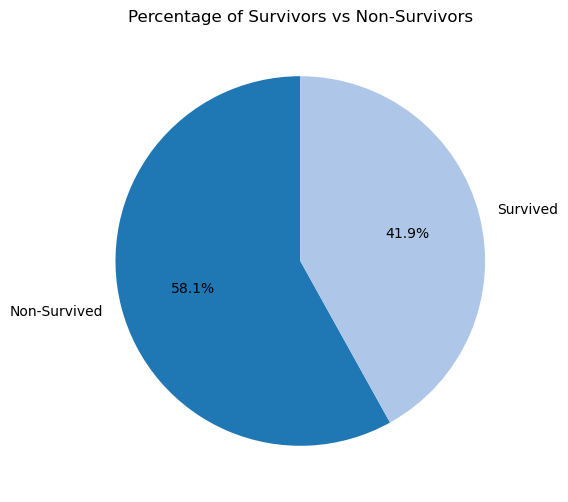

In [10]:
# Calculate counts of survivors and non-survivors
survived_counts = df_train_no_dup['Survived'].value_counts()

# Plot pie chart to visualize the proportion of survivors and non-survivors
plt.figure(figsize=(8, 6))
plt.pie(survived_counts, labels=['Non-Survived', 'Survived'], autopct='%1.1f%%', startangle=90, colors=plt.cm.tab20.colors)
plt.title('Percentage of Survivors vs Non-Survivors')
plt.show()

In [25]:
# Calculate counts of survivors and non-survivors for each age group in both 10-year and 20-year bins
survived_counts_10 = df_train_10[df_train_10['Survived'] == 1]['AgeGroup'].value_counts()
survived_counts_20 = df_train_20[df_train_20['Survived'] == 1]['AgeGroup'].value_counts()

died_counts_10 = df_train_10[df_train_10['Survived'] == 0]['AgeGroup'].value_counts()
died_counts_20 = df_train_20[df_train_20['Survived'] == 0]['AgeGroup'].value_counts()

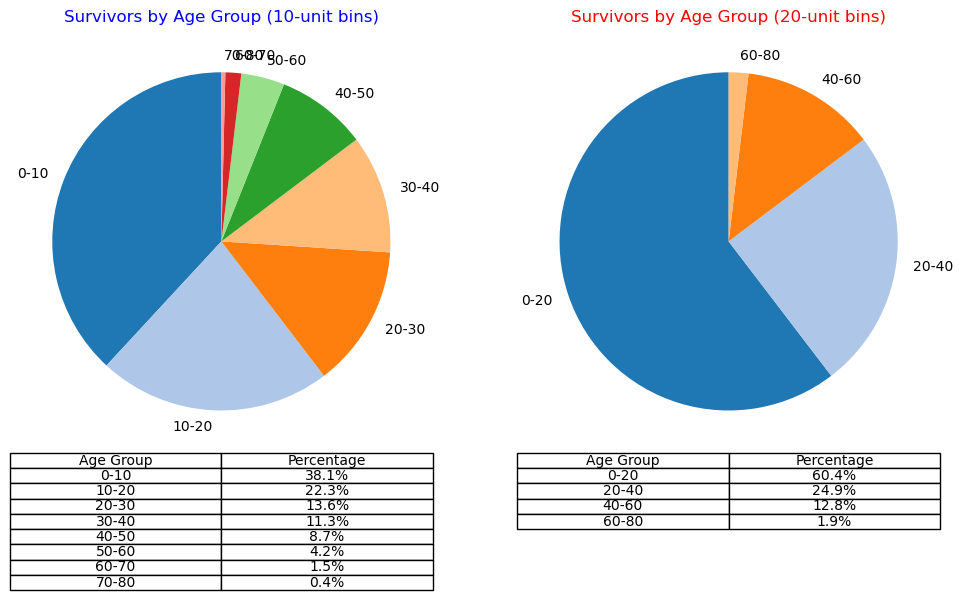

In [12]:
# Define age group labels for plotting
age_labels_20 = ['0-20','20-40','40-60','60-80']
age_labels_10 = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80']

# Plotting pie charts for survivors by age group
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for survivors in 10-unit bins
axes[0].pie(survived_counts_10, labels=age_labels_10, startangle=90, colors=plt.cm.tab20.colors)
axes[0].set_title('Survivors by Age Group (10-unit bins)',color="blue")

# Create a table below the pie chart for 10-unit bins
table_data_10 = [[label, f'{val:.1f}%'] for label, val in zip(age_labels_10, (survived_counts_10 / survived_counts_10.sum()) * 100)]
axes[0].table(cellText=table_data_10, colLabels=['Age Group', 'Percentage'], cellLoc='center', loc='bottom')

# Pie chart for survivors in 20-unit bins
axes[1].pie(survived_counts_20, labels=age_labels_20, startangle=90, colors=plt.cm.tab20.colors)
axes[1].set_title('Survivors by Age Group (20-unit bins)',color="red")

# Create a table below the pie chart for 20-unit bins
table_data_20 = [[label, f'{val:.1f}%'] for label, val in zip(age_labels_20, (survived_counts_20 / survived_counts_20.sum()) * 100)]
axes[1].table(cellText=table_data_20, colLabels=['Age Group', 'Percentage'], cellLoc='center', loc='bottom')


plt.show()

<AxesSubplot:xlabel='Pclass', ylabel='count'>

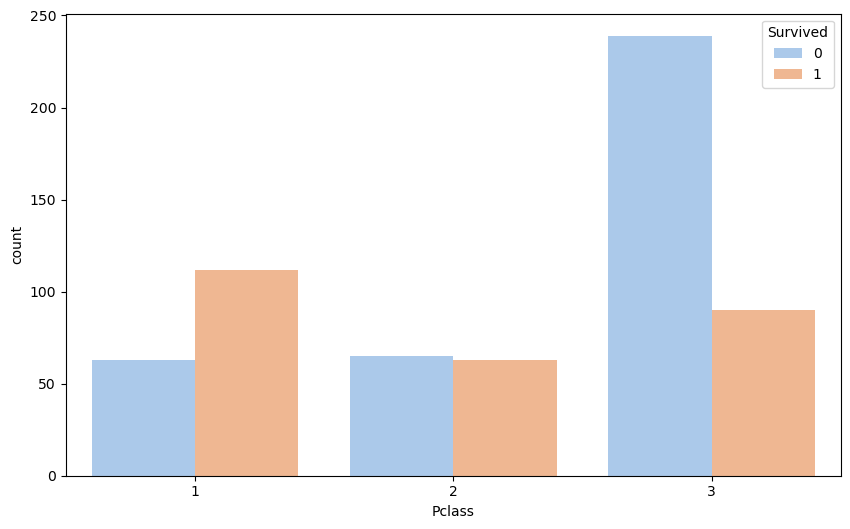

In [26]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train_no_dup, x='Pclass', hue='Survived', palette='pastel')

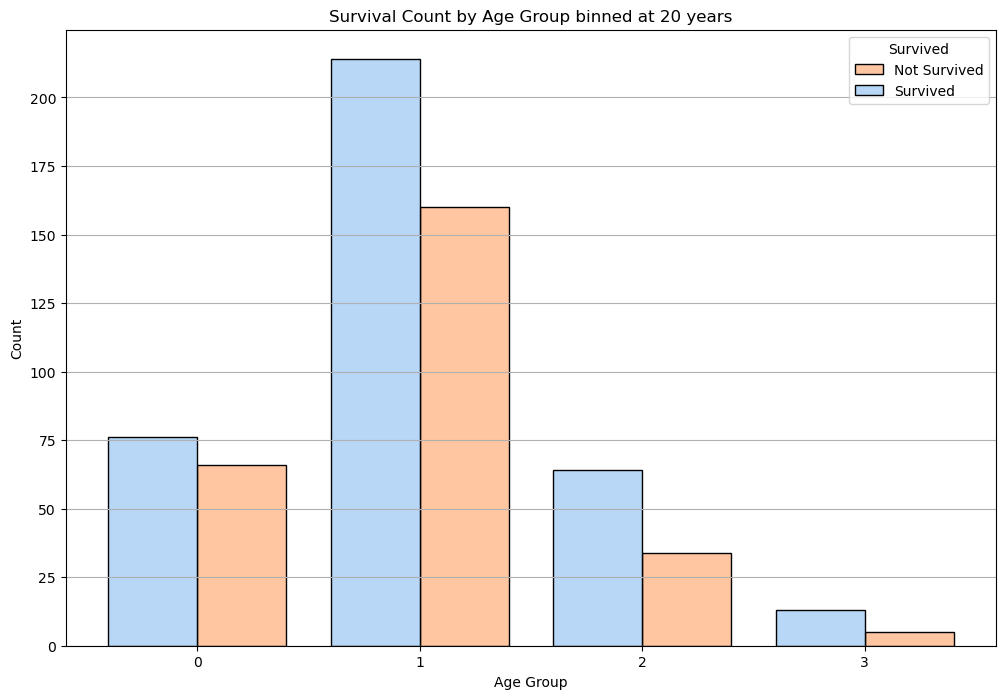

In [13]:
# Plot histogram to visualize survival count by age group (20-year bins)
plt.figure(figsize=(12, 8))
sns.histplot(data=df_train_20, x='AgeGroup', hue='Survived', multiple='dodge', shrink=0.8, palette='pastel', discrete=True)

# Adding titles and labels
plt.title('Survival Count by Age Group binned at 20 years')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['Not Survived', 'Survived'])
plt.xticks(ticks=[0, 1, 2, 3], labels=['0', '1', '2', '3'])
plt.grid(True, axis='y')
plt.show()    


## Part 3 - Experiments
You could add as many code cells as needed

In [14]:
# Create new versions of the datasets with feature engineering
df_train_20_related = df_train_20.copy()
df_train_10_related = df_train_10.copy()

# Feature engineering for 'Related' (creating a new feature)
df_train_20_related['Related'] = df_train_20_related.apply(lambda row: 0 if row['SibSp'] == 0 and row['Parch'] == 0 else 1, axis=1)
df_train_10_related['Related'] = df_train_10_related.apply(lambda row: 0 if row['SibSp'] == 0 and row['Parch'] == 0 else 1, axis=1)

# Remove 'SibSp' and 'Parch' columns after creating 'Related'
df_train_10_related.drop(columns=['SibSp','Parch'],inplace=True)
df_train_20_related.drop(columns=['SibSp','Parch'],inplace=True)

# Move 'Survived' column to the end of the dataframe
target_col = df_train_10_related.pop('Survived')
df_train_10_related['Survived'] = target_col

target_col = df_train_20_related.pop('Survived')
df_train_20_related['Survived'] = target_col

In [15]:
# Printing the view of the different datasets
print("df_train_no_dup")
display(df_train_no_dup.head(5))

print("10")
display(df_train_10.head(5))

print("20")
display(df_train_20.head(5))

print("10 + related")
display(df_train_10_related.head(5))

print("20 + related")
display(df_train_20_related.head(5))

# Cross-tab tables between 'Related' and 'Survived'
age_20_related_survived_crosstab = pd.crosstab(df_train_20_related['Related'], df_train_20_related['Survived'])
age_10_related_survived_crosstab = pd.crosstab(df_train_10_related['Related'], df_train_10_related['Survived'])

display(age_20_related_survived_crosstab)
display(age_10_related_survived_crosstab)


df_train_no_dup


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


10


,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeGroup,Survived
0,1,0,1,0,78.2667,1,5,1
1,2,0,0,0,13.5000,0,4,1
2,3,1,0,0,9.5000,0,1,0
3,3,1,0,0,7.8958,0,3,0
4,3,1,0,0,8.0500,0,2,0


20


,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeGroup,Survived
0,1,0,1,0,78.2667,1,2,1
1,2,0,0,0,13.5000,0,2,1
2,3,1,0,0,9.5000,0,0,0
3,3,1,0,0,7.8958,0,1,0
4,3,1,0,0,8.0500,0,1,0


10 + related


,Pclass,Sex,Fare,Embarked,AgeGroup,Related,Survived
0,1,0,78.2667,1,5,1,1
1,2,0,13.5000,0,4,0,1
2,3,1,9.5000,0,1,0,0
3,3,1,7.8958,0,3,0,0
4,3,1,8.0500,0,2,0,0


20 + related


,Pclass,Sex,Fare,Embarked,AgeGroup,Related,Survived
0,1,0,78.2667,1,2,1,1
1,2,0,13.5000,0,2,0,1
2,3,1,9.5000,0,0,0,0
3,3,1,7.8958,0,1,0,0
4,3,1,8.0500,0,1,0,0


Survived,0,1
Related,,
0,227,125
1,140,140


Survived,0,1
Related,,
0,227,125
1,140,140


In [16]:
# Function to build X (features) and y (target) from a dataset
def build_X_y_from_ds(df, target_col):
    df_cp = df.copy()
    X = df_cp.drop([target_col], axis=1)
    y = df_cp[target_col]
    return X, y

# Preparing X and y for each dataset after feature engineering
X_train_no_dup, y_train_no_dup = build_X_y_from_ds(df_train_no_dup,"Survived")
X_train_10, y_train_10 = build_X_y_from_ds(df_train_10,"Survived")
X_train_10_related, y_train_10_related = build_X_y_from_ds(df_train_10_related,"Survived")
X_train_20, y_train_20 = build_X_y_from_ds(df_train_20,"Survived")
X_train_20_related, y_train_20_related = build_X_y_from_ds(df_train_20_related,"Survived")


In [17]:
# 5 datasets with various feature engineering
datasets = [df_train_no_dup, df_train_10,df_train_20,df_train_10_related, df_train_20_related]

In [18]:
# Define grid search for Decision Tree
param_grid = {
    'criterion': ['entropy'],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'min_samples_leaf': [1, 2, 3, 4]
}

# Lists to store the best models and their corresponding F1 scores
best_models = []
best_f1_scores = []

# Iterate through each dataset and perform grid search
for idx, dataset in enumerate(datasets, start=1):
    X, y = build_X_y_from_ds(dataset, "Survived")
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize Decision Tree classifier
    dtree = DecisionTreeClassifier(random_state=42)
    
    # Perform grid search with 5-fold cross-validation
    grid_search = GridSearchCV(estimator=dtree, param_grid=param_grid, cv=5, scoring='f1', verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    best_models.append(best_model)
    
    # Evaluate the model on the test set
    y_pred = best_model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    best_f1_scores.append(f1)
    
    # Print results for each dataset
    print(f'Dataset {idx}: Best Parameters - {grid_search.best_params_}, Test f1_score - {f1:.4f}')

# Determine the best performing dataset
best_idx = best_f1_scores.index(max(best_f1_scores))
best_dataset = datasets[best_idx]
best_model = best_models[best_idx]

print(f'Best performing dataset is Dataset {best_idx + 1} with f1_score {best_f1_scores[best_idx]:.4f}')


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Dataset 1: Best Parameters - {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}, Test f1_score - 0.7573
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Dataset 2: Best Parameters - {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 2}, Test f1_score - 0.7778
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Dataset 3: Best Parameters - {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 1}, Test f1_score - 0.7308
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Dataset 4: Best Parameters - {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1}, Test f1_score - 0.7636
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Dataset 5: Best Parameters - {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 4}, Test f1_score - 0.7000
Best performing dataset is Dataset 2 with f1_score 0.7778


In [19]:
# Define parameter grids for KNN
n_neighbors = [2, 3, 4, 5, 6]
metrics = ['chebyshev', 'manhattan']
weights = ['uniform', 'distance']

# Initialize variables to store best parameters and accuracy across all datasets
best_params_overall = {'dataset': None, 'params': None, 'f1': 0.0}

# Iterate through each dataset
for idx, data in enumerate(datasets, start=1):
    print(f"Processing Dataset {idx}")
    
    X, y = build_X_y_from_ds(data,"Survived")
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Perform grid search for KNN parameters
    best_params = {'n_neighbors': None, 'metric': None, 'weights': None}
    best_f1 = 0.0
    
    for k in n_neighbors:
        for m in metrics:
            for w in weights:
                # Initialize KNN classifier with current parameters
                knn = KNeighborsClassifier(n_neighbors=k, metric=m, weights=w)
                
                # Fit the classifier on scaled training data
                knn.fit(X_train_scaled, y_train)
                
                # Predict on the scaled test data
                y_pred = knn.predict(X_test_scaled)
                
                # Evaluate the model f1 score
                f1 = f1_score(y_test, y_pred)
                
                # Update best parameters and f1 score if current model is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_params['n_neighbors'] = k
                    best_params['metric'] = m
                    best_params['weights'] = w
    
    # Print best parameters and accuracy for the current dataset
    print(f"Best parameters for Dataset {idx}: {best_params}")
    print(f"Best f1_score for Dataset {idx}: {best_f1}\n")
    
    # Check if this dataset has the best accuracy compared to others
    if best_f1 > best_params_overall['f1']:
        best_params_overall['dataset'] = f"Dataset {idx}"
        best_params_overall['params'] = best_params.copy()
        best_params_overall['f1'] = best_f1

# Print overall best parameters and accuracy found across all datasets
print("Overall Best Parameters:")
print(best_params_overall['params'])
print("Overall Best f1 score:")
print(best_params_overall['f1'])


Processing Dataset 1
Best parameters for Dataset 1: {'n_neighbors': 3, 'metric': 'manhattan', 'weights': 'distance'}
Best f1_score for Dataset 1: 0.7692307692307693

Processing Dataset 2
Best parameters for Dataset 2: {'n_neighbors': 6, 'metric': 'chebyshev', 'weights': 'uniform'}
Best f1_score for Dataset 2: 0.7755102040816325

Processing Dataset 3
Best parameters for Dataset 3: {'n_neighbors': 5, 'metric': 'chebyshev', 'weights': 'uniform'}
Best f1_score for Dataset 3: 0.7735849056603775

Processing Dataset 4
Best parameters for Dataset 4: {'n_neighbors': 5, 'metric': 'manhattan', 'weights': 'uniform'}
Best f1_score for Dataset 4: 0.7636363636363636

Processing Dataset 5
Best parameters for Dataset 5: {'n_neighbors': 4, 'metric': 'chebyshev', 'weights': 'uniform'}
Best f1_score for Dataset 5: 0.7628865979381443

Overall Best Parameters:
{'n_neighbors': 6, 'metric': 'chebyshev', 'weights': 'uniform'}
Overall Best f1 score:
0.7755102040816325


In [20]:
# Store results for comparison
results_summary = []

# Adding the obtained results
for idx, dataset in enumerate(datasets, start=1):
    results_summary.append({
        'Dataset': f'Dataset {idx}',
        'Decision Tree F1': best_f1_scores[idx-1],
        'KNN F1': best_params_overall['f1']
    })

# Create a DataFrame for the summary results
results_df = pd.DataFrame(results_summary)
display(results_df)


,Dataset,Decision Tree F1,KNN F1
0,Dataset 1,0.757282,0.77551
1,Dataset 2,0.777778,0.77551
2,Dataset 3,0.730769,0.77551
3,Dataset 4,0.763636,0.77551
4,Dataset 5,0.700000,0.77551


## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [21]:
# Train the best model on the entire best dataset
X_best, y_best = build_X_y_from_ds(df_train_10, "Survived")


# parameters as found above
best_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth = 6,
    min_samples_leaf = 2,
    random_state=42
)

# Train the model on the training set
best_model.fit(X_best, y_best)


DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=2,
                       random_state=42)

## Part 5 - Apply on test and show model performance estimation

In [22]:
# Apply the same age binning to the test set as done on the training set
bins_10 = [0,10,20,30,40,50,60,70,80]
labels_10 = [0,1,2,3,4,5,6,7]

df_test['AgeGroup'] = pd.cut(df_test['Age'], bins=bins_10, labels=labels_10, right=True)
df_test['AgeGroup'] = df_test['AgeGroup'].cat.codes


df_test.drop(columns='Age',inplace=True)

# Move the 'Survived' column to the end (assuming it exists in the test set for evaluation)
target_col = df_test.pop('Survived')
df_test['Survived'] = target_col

df_test.head(5)



,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeGroup,Survived
0,3,1,0,0,7.0500,0,3,0
1,3,1,0,0,7.2500,0,2,0
2,3,1,0,0,14.5000,0,2,0
3,3,0,0,0,7.7500,2,2,0
4,3,1,0,0,56.4958,0,3,1


In [23]:
# Prepare features (X_test) and target variable (y_test) from the test set
X_test, y_test = build_X_y_from_ds(df_test,'Survived')

In [24]:
# Predict the target values for the test set
y_pred = best_model.predict(X_test)

# Evaluate the model using various metrics
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the evaluation results
print(f'Test F1 Score: {f1:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

print()
print('Classification Report:')
print(class_report)

Test F1 Score: 0.7797
Test Accuracy: 0.8547
Test Precision: 0.8070
Test Recall: 0.7541
Confusion Matrix:
[[107  11]
 [ 15  46]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       118
           1       0.81      0.75      0.78        61

    accuracy                           0.85       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179

